<a href="https://colab.research.google.com/github/springboardmentor5432x/DV---Optimizing-IT-Support-Team-Performance-Using-Analytics-Supportlytics-/blob/Gokul-Optimizing-IT-Support-Team-Performance-Using-Analytics-(-Supportlytics)/milestone_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Milestone 1: Week 1-2**

 Module 1:- Project Initialization and Dataset Setup

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('Supportlytics.csv')
df.head()

,Ticket_ID,Status,Priority,Source,Topic,Category,Agent_Group,Created_time,Expected_SLA_resolve,Resolution_Duration,SLA_Status,Survey_Results,Country,Latitude,Longitude,Agent_interactions
0,TIC-5000,Closed,Critical,Chat,Access Revoked,Security,Network Ops,25-11-2025 07:14,4,2.84,On-Time,3.0,Germany,51.16,10.45,6
1,TIC-5001,Closed,Medium,Email,Wi-Fi Access,Network,Infrastructure,19-07-2025 11:09,24,27.19,Breached,4.0,Germany,51.16,10.45,8
2,TIC-5002,Resolved,Critical,Chat,Printer,Hardware,L2 Technical Support,01-05-2025 22:29,4,2.96,On-Time,NaN,India,20.59,78.96,2
3,TIC-5003,Closed,High,Email,Bug Report,Software,Security Admin,19-06-2025 07:21,8,1.89,On-Time,2.0,UK,55.37,-3.43,8
4,TIC-5004,Closed,Low,Chat,Update Failure,Software,L1 Service Desk,17-01-2025 06:30,48,10.85,On-Time,2.0,Brazil,-14.23,-51.92,3


In [ ]:
df['Created_time'] = pd.to_datetime(df['Created_time'], dayfirst=True)

class DataProfiler:
    def __init__(self, data):
        self.data = data

    def health_check(self):
        profile = pd.DataFrame({
            'Data Type': self.data.dtypes,
            'Missing Values': self.data.isnull().sum(),
            'Unique Values': self.data.nunique(),
            'Completeness (%)': (1 - self.data.isnull().sum() / len(self.data)) * 100
        })
        return profile

# Execute Health Check
profiler = DataProfiler(df)
print("\n--- Advanced Data Health Report ---")
display(profiler.health_check())


--- Advanced Data Health Report ---


,Data Type,Missing Values,Unique Values,Completeness (%)
Ticket_ID,object,0,5000,100.00
Status,object,0,3,100.00
Priority,object,0,4,100.00
Source,object,0,4,100.00
Topic,object,0,16,100.00
Category,object,0,4,100.00
Agent_Group,object,0,5,100.00
Created_time,datetime64[ns],0,4974,100.00
Expected_SLA_resolve,int64,0,4,100.00
Resolution_Duration,float64,236,3109,95.28


In [ ]:
# 1. Flagging original missing values (Requirement for Milestone 1)
df['Resolution_Imputed'] = df['Resolution_Duration'].isnull().astype(int)
df['Survey_Imputed'] = df['Survey_Results'].isnull().astype(int)

# 2. Advanced Imputation for Resolution Duration
# Only impute for Closed/Resolved tickets to avoid skewing 'Open' ticket metrics
mask = (df['Status'].isin(['Closed', 'Resolved'])) & (df['Resolution_Duration'].isnull())
df.loc[mask, 'Resolution_Duration'] = df[mask].groupby(['Category', 'Priority'])['Resolution_Duration'].transform(
    lambda x: x.fillna(x.median() if not np.isnan(x.median()) else df['Resolution_Duration'].median())
)

# 3. Neutral Imputation for Survey Results
avg_sat = df['Survey_Results'].mean()
df['Survey_Results'] = df['Survey_Results'].fillna(avg_sat)

print("\n[Data Cleaning Complete]: Missing values handled using Grouped Median and Global Mean logic.")

# Metric Definitions & Distributions

# Metric A: Resolution Gap (Expected vs Actual)
df['Resolution_Gap'] = df['Expected_SLA_resolve'] - df['Resolution_Duration']

# Metric B: Response Efficiency (Expected SLA / Interactions)
df['Response_Efficiency'] = df['Expected_SLA_resolve'] / (df['Agent_interactions'] + 1)

# Metric C: Initial Distribution Analysis
print("\n--- Ticket Distribution: Priority ---")
display(df['Priority'].value_counts().to_frame())

print("\n--- Multi-Factor Distribution: Category x Priority ---")
dist_matrix = pd.crosstab(df['Category'], df['Priority'], margins=True, margins_name="Total")
display(dist_matrix)


[Data Cleaning Complete]: Missing values handled using Grouped Median and Global Mean logic.

--- Ticket Distribution: Priority ---


,count
Priority,
Medium,2003
Low,1528
High,975
Critical,494



--- Multi-Factor Distribution: Category x Priority ---


Priority,Critical,High,Low,Medium,Total
Category,,,,,
Hardware,116,255,412,515,1298
Network,126,236,406,487,1255
Security,121,246,343,485,1195
Software,131,238,367,516,1252
Total,494,975,1528,2003,5000


**Module** 2: Similarity Level & Performance Bucketing

In [ ]:


# 1. Normalize the metrics to a 0-1 scale for comparison
# Speed Score: 1 is best (instant), 0 is worst (slow)
df['Normalized_Speed'] = 1 - (df['Resolution_Duration'] / df['Expected_SLA_resolve'].replace(0, 1))
# Satisfaction Score: 1 is best (5/5), 0 is worst (1/5)
df['Normalized_Satisfaction'] = (df['Survey_Results'] - 1) / 4

# 2. Define the Similarity_Level (Weighted Average)
# We give 60% weight to SLA Speed and 40% to Customer Satisfaction
df['Similarity_Score'] = (df['Normalized_Speed'] * 0.6) + (df['Normalized_Satisfaction'] * 0.4)

# Handle cases where Speed might be negative (massive SLA breach)
df['Similarity_Score'] = df['Similarity_Score'].clip(lower=0, upper=1)

print("Similarity Scores calculated based on Speed and Satisfaction.")

Similarity Scores calculated based on Speed and Satisfaction.


*  Categorizing Similarity_Level into performance buckets

In [ ]:

def get_performance_bucket(score):
    if pd.isna(score): return "Pending"
    if score >= 0.75: return "High Performer"
    if score >= 0.40: return "Standard"
    return "Low Efficiency"

df['Performance_Bucket'] = df['Similarity_Score'].apply(get_performance_bucket)

# 4. Final Review of the Buckets
bucket_dist = df['Performance_Bucket'].value_counts()
print("\n--- Performance Bucket Distribution ---")
print(bucket_dist)


--- Performance Bucket Distribution ---
Performance_Bucket
Low Efficiency    3022
Standard          1481
High Performer     261
Pending            236
Name: count, dtype: int64


In [ ]:
df.rename(columns={'Topic': 'Queue'}, inplace=True)
df.head()

,Ticket_ID,Status,Priority,Source,Queue,Category,Agent_Group,Created_time,Expected_SLA_resolve,Resolution_Duration,...,Longitude,Agent_interactions,Resolution_Imputed,Survey_Imputed,Resolution_Gap,Response_Efficiency,Normalized_Speed,Normalized_Satisfaction,Similarity_Score,Performance_Bucket
0,TIC-5000,Closed,Critical,Chat,Access Revoked,Security,Network Ops,2025-11-25 07:14:00,4,2.84,...,10.45,6,0,0,1.16,0.571429,0.290000,0.500000,0.374000,Low Efficiency
1,TIC-5001,Closed,Medium,Email,Wi-Fi Access,Network,Infrastructure,2025-07-19 11:09:00,24,27.19,...,10.45,8,0,0,-3.19,2.666667,-0.132917,0.750000,0.220250,Low Efficiency
2,TIC-5002,Resolved,Critical,Chat,Printer,Hardware,L2 Technical Support,2025-05-01 22:29:00,4,2.96,...,78.96,2,0,1,1.04,1.333333,0.260000,0.505661,0.358264,Low Efficiency
3,TIC-5003,Closed,High,Email,Bug Report,Software,Security Admin,2025-06-19 07:21:00,8,1.89,...,-3.43,8,0,0,6.11,0.888889,0.763750,0.250000,0.558250,Standard
4,TIC-5004,Closed,Low,Chat,Update Failure,Software,L1 Service Desk,2025-01-17 06:30:00,48,10.85,...,-51.92,3,0,0,37.15,12.000000,0.773958,0.250000,0.564375,Standard


In [ ]:
df.to_csv('cleaned_Supportlytics.csv', index=False)

**Milestone 2: Week 3-4**

module-3

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (8,5)
sns.set_style("whitegrid")

In [ ]:
df = pd.read_csv('/content/cleaned_Supportlytics.csv')
df.head()


,Ticket_ID,Status,Priority,Source,Queue,Category,Agent_Group,Created_time,Expected_SLA_resolve,Resolution_Duration,...,Longitude,Agent_interactions,Resolution_Imputed,Survey_Imputed,Resolution_Gap,Response_Efficiency,Normalized_Speed,Normalized_Satisfaction,Similarity_Score,Performance_Bucket
0,TIC-5000,Closed,Critical,Chat,Access Revoked,Security,Network Ops,2025-11-25 07:14:00,4,2.84,...,10.45,6,0,0,1.16,0.571429,0.290000,0.500000,0.374000,Low Efficiency
1,TIC-5001,Closed,Medium,Email,Wi-Fi Access,Network,Infrastructure,2025-07-19 11:09:00,24,27.19,...,10.45,8,0,0,-3.19,2.666667,-0.132917,0.750000,0.220250,Low Efficiency
2,TIC-5002,Resolved,Critical,Chat,Printer,Hardware,L2 Technical Support,2025-05-01 22:29:00,4,2.96,...,78.96,2,0,1,1.04,1.333333,0.260000,0.505661,0.358264,Low Efficiency
3,TIC-5003,Closed,High,Email,Bug Report,Software,Security Admin,2025-06-19 07:21:00,8,1.89,...,-3.43,8,0,0,6.11,0.888889,0.763750,0.250000,0.558250,Standard
4,TIC-5004,Closed,Low,Chat,Update Failure,Software,L1 Service Desk,2025-01-17 06:30:00,48,10.85,...,-51.92,3,0,0,37.15,12.000000,0.773958,0.250000,0.564375,Standard


In [ ]:
print("--- Performance Bucket Distribution ---")
display(df['Performance_Bucket'].value_counts().to_frame())

--- Performance Bucket Distribution ---


,count
Performance_Bucket,
Low Efficiency,3022
Standard,1481
High Performer,261
Pending,236


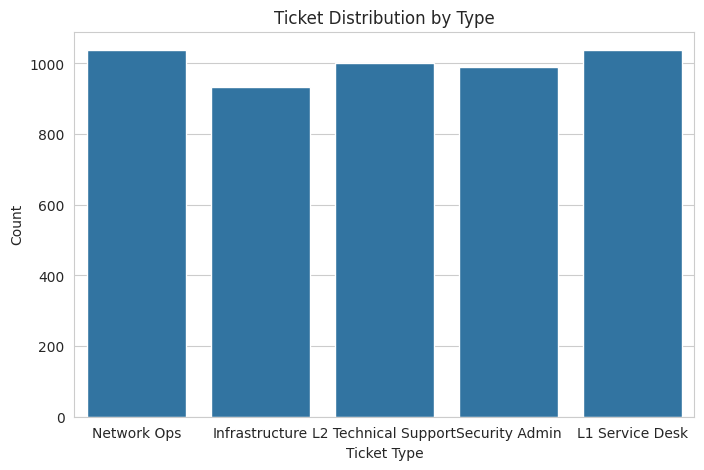

In [ ]:
sns.countplot(data=df, x='Agent_Group')
plt.title('Ticket Distribution by Type')
plt.xlabel('Ticket Type')
plt.ylabel('Count')
plt.show()

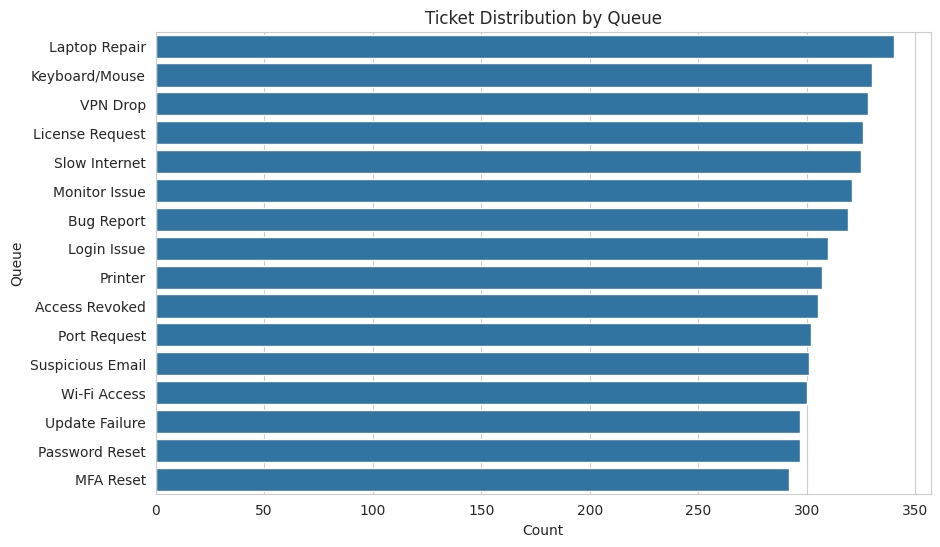

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='Queue', order=df['Queue'].value_counts().index)
plt.title('Ticket Distribution by Queue')
plt.xlabel('Count')
plt.ylabel('Queue')
plt.show()

In [ ]:
print("--- Top Categories by Frequency ---")
display(df['Category'].value_counts().to_frame())

--- Top Categories by Frequency ---


,count
Category,
Hardware,1298
Network,1255
Software,1252
Security,1195


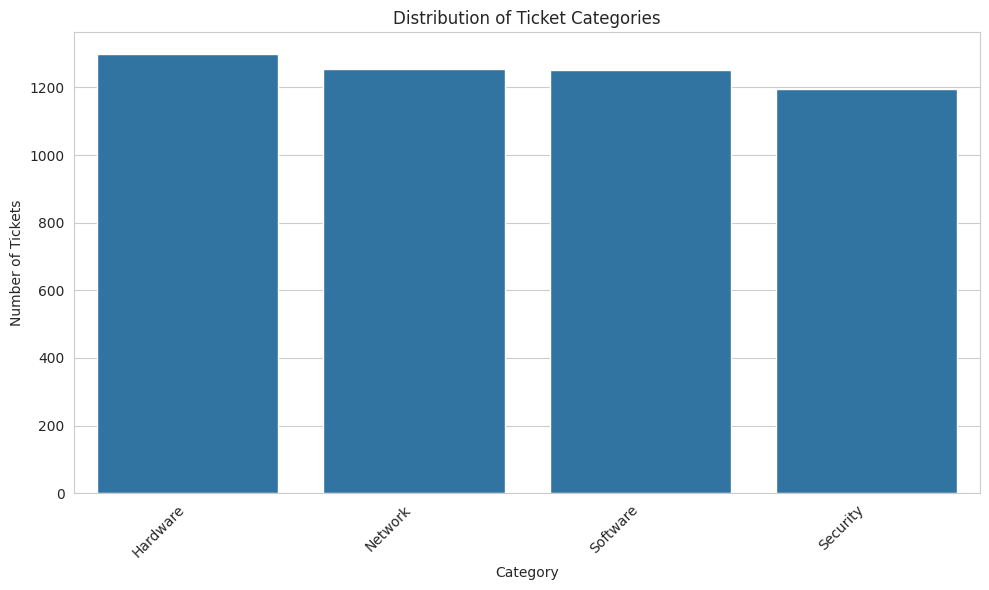

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df['Category'].value_counts().index, y=df['Category'].value_counts().values)
plt.title('Distribution of Ticket Categories')
plt.xlabel('Category')
plt.ylabel('Number of Tickets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

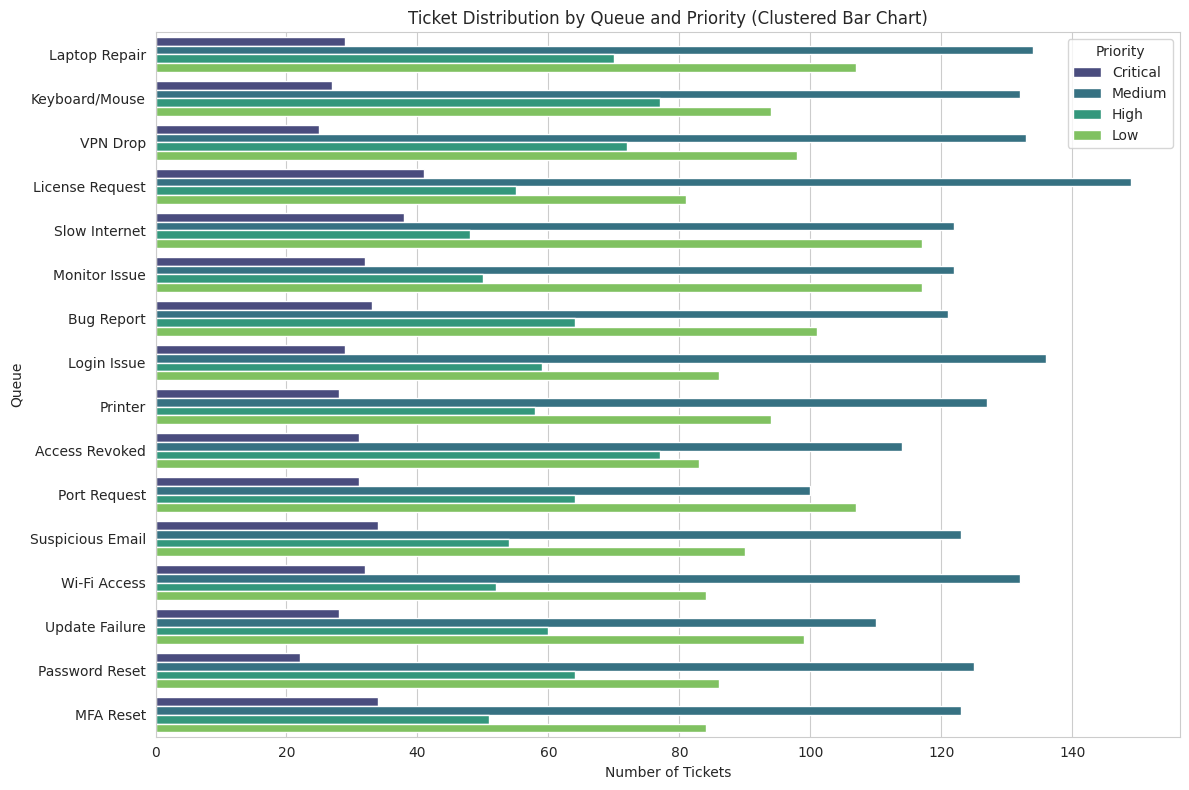

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, y='Queue', hue='Priority', order=df['Queue'].value_counts().index, palette='viridis')
plt.title('Ticket Distribution by Queue and Priority (Clustered Bar Chart)')
plt.xlabel('Number of Tickets')
plt.ylabel('Queue')
plt.legend(title='Priority')
plt.tight_layout()
plt.show()

module-4 Similarity  and cluster insight

Select numerical features for clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
features = [
    'Resolution_Duration',
    'Expected_SLA_resolve',
    'Agent_interactions',
    'Normalized_Speed',
    'Normalized_Satisfaction',
    'Similarity_Score'
]

Handle potential NaN values in selected features before scaling

In [ ]:
df_clustering = df[features].dropna()

Scale the features

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)

print("Features selected and scaled for clustering.")

Features selected and scaled for clustering.


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10) # n_init added for best practices

# Predict clusters only for the rows that were used for clustering (i.e., not dropped NaN rows)
df.loc[df_clustering.index, 'Cluster_ID'] = kmeans.fit_predict(X_scaled)

print("K-Means clustering performed successfully, 'Cluster_ID' created.")

K-Means clustering performed successfully, 'Cluster_ID' created.


In [ ]:
print("--- Cluster Characteristics (Mean Values) ---")
display(df.groupby('Cluster_ID')[features].mean())

--- Cluster Characteristics (Mean Values) ---


,Resolution_Duration,Expected_SLA_resolve,Agent_interactions,Normalized_Speed,Normalized_Satisfaction,Similarity_Score
Cluster_ID,,,,,,
0.0,20.615010,16.637407,4.238352,-0.238135,0.441867,0.100403
1.0,9.908706,20.917431,7.475229,0.483323,0.291960,0.406902
2.0,54.012490,48.000000,4.763598,-0.125260,0.471767,0.163839
3.0,12.369992,25.539208,4.836702,0.490890,0.796537,0.613149


In [ ]:
df[['Cluster_ID','Similarity_Score', 'Resolution_Duration' ]].head()

,Cluster_ID,Similarity_Score,Resolution_Duration
0,1.0,0.374000,2.84
1,0.0,0.220250,27.19
2,0.0,0.358264,2.96
3,1.0,0.558250,1.89
4,3.0,0.564375,10.85


In [ ]:
cluster_similarity = (
    df.groupby('Cluster_ID')['Similarity_Score']
      .mean()
      .sort_values(ascending=False)
)

cluster_similarity

,Similarity_Score
Cluster_ID,
3.0,0.613149
1.0,0.406902
2.0,0.163839
0.0,0.100403


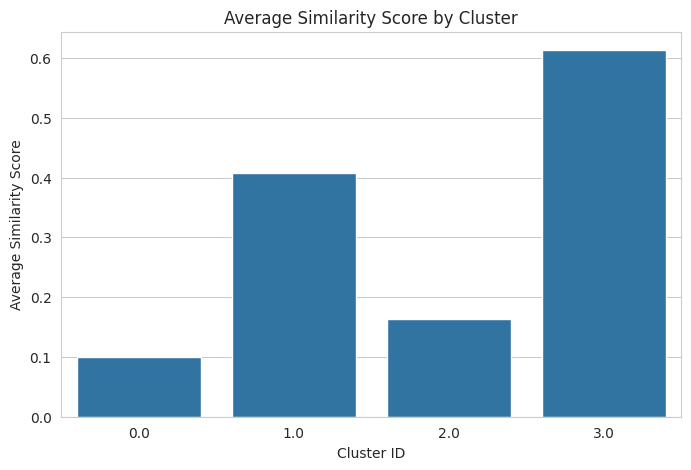

In [ ]:
sns.barplot(x=cluster_similarity.index, y=cluster_similarity.values)
plt.title('Average Similarity Score by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Average Similarity Score')
plt.show()


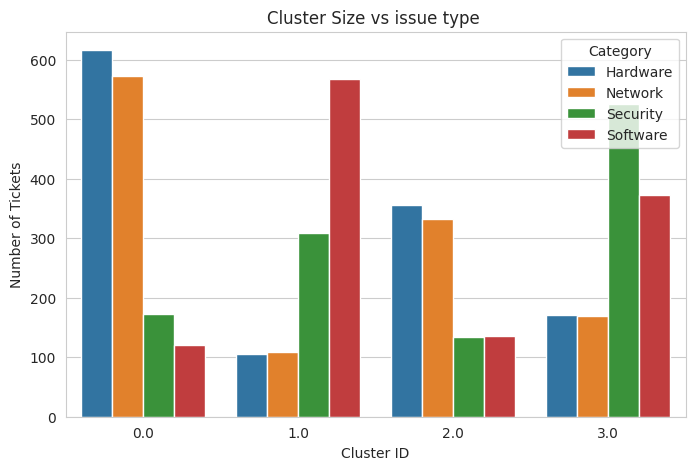

In [ ]:

cluster_size = df.groupby(['Cluster_ID', 'Category']).size().reset_index(name='Count')

sns.barplot(data=cluster_size, x='Cluster_ID', y='Count', hue='Category')
plt.title('Cluster Size vs issue type ')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Tickets')
plt.show()

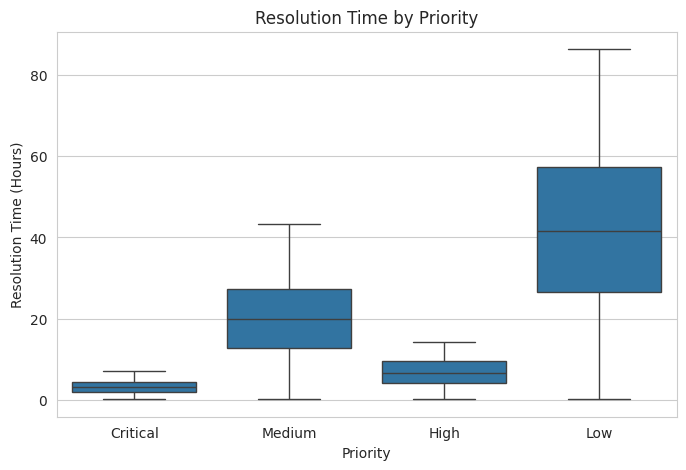

In [ ]:
sns.boxplot(data=df, x='Priority', y='Resolution_Duration')
plt.title('Resolution Time by Priority')
plt.xlabel('Priority')
plt.ylabel('Resolution Time (Hours)')
plt.show()

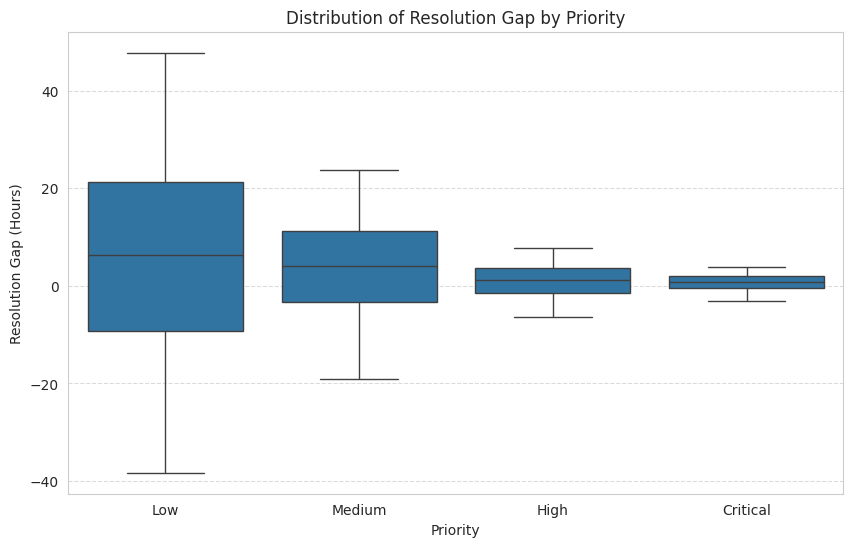

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Priority', y='Resolution_Gap', order=['Low', 'Medium', 'High', 'Critical'])
plt.title('Distribution of Resolution Gap by Priority')
plt.xlabel('Priority')
plt.ylabel('Resolution Gap (Hours)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

MILESTION-3

Module 5:- Performance Trend Analysis

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/content/cleaned_Supportlytics.csv')


Analyze the average resolution time for high-priority tickets, grouped by country and category, and visualize these insights using bar plots.

In [ ]:
high_priority_df = df[df['Priority'] == 'High']
avg_resolution_country = high_priority_df.groupby('Country')['Resolution_Duration'].mean().sort_values(ascending=False)
print("--- Average Resolution Duration for High Priority Tickets by Country ---")
display(avg_resolution_country)

--- Average Resolution Duration for High Priority Tickets by Country ---


,Resolution_Duration
Country,
Germany,7.223316
UK,6.889706
Brazil,6.843908
India,6.697872
USA,6.655920


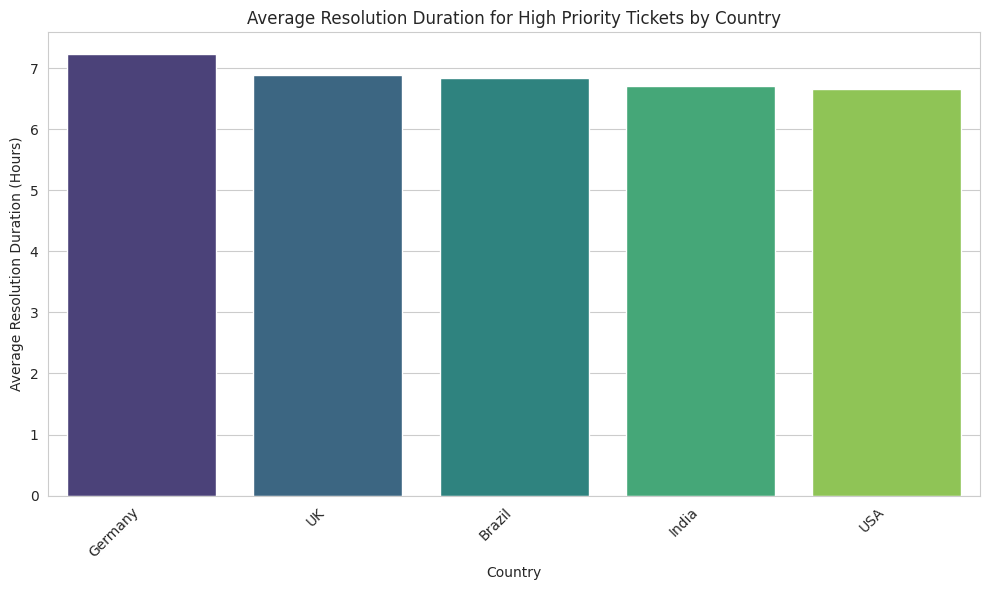

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_resolution_country.index, y=avg_resolution_country.values, hue=avg_resolution_country.index, palette='viridis', legend=False)
plt.title('Average Resolution Duration for High Priority Tickets by Country')
plt.xlabel('Country')
plt.ylabel('Average Resolution Duration (Hours)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
Now that the average resolution duration for high-priority tickets by country has been visualized, the next step is to calculate the average resolution duration for high-priority tickets, grouped by 'Category' as specified in the main task, and then display the results.



In [ ]:
avg_resolution_category = high_priority_df.groupby('Category')['Resolution_Duration'].mean().sort_values(ascending=False)
print("--- Average Resolution Duration for High Priority Tickets by Category ---")
display(avg_resolution_category)

--- Average Resolution Duration for High Priority Tickets by Category ---


,Resolution_Duration
Category,
Hardware,9.373210
Network,8.885491
Software,4.746593
Security,4.374615


**Reasoning**:
To visually represent the average resolution duration for high-priority tickets by category, a bar plot is appropriate for comparing these categorical values.



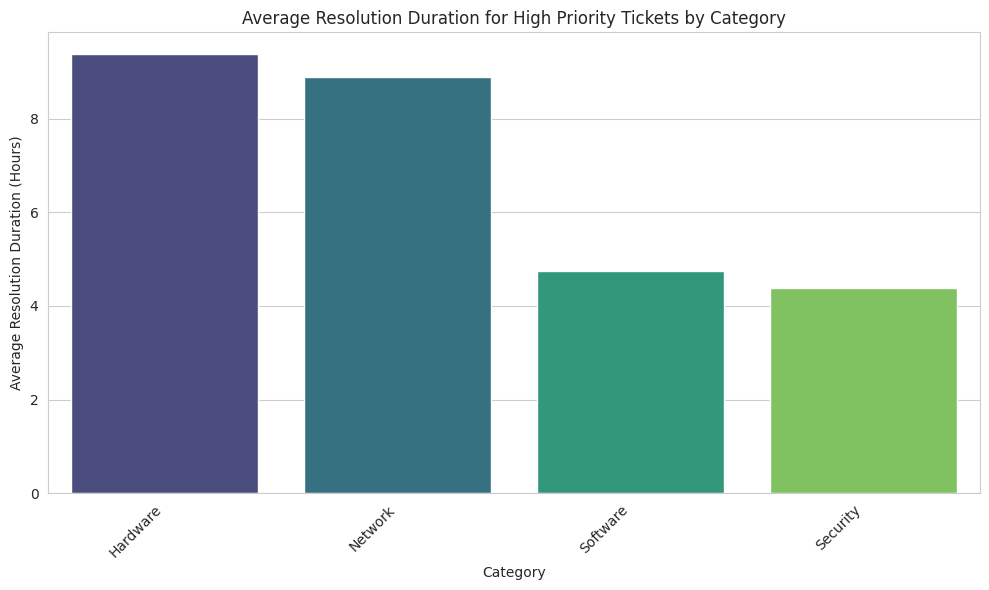

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_resolution_category.index, y=avg_resolution_category.values, hue=avg_resolution_category.index, palette='viridis', legend=False)
plt.title('Average Resolution Duration for High Priority Tickets by Category')
plt.xlabel('Category')
plt.ylabel('Average Resolution Duration (Hours)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
high_priority_unresolved = df[
    (df['Priority'].isin(['High','Critical'])) &
    (df['Status'] != 'Resolved')
]

high_priority_unresolved[['Ticket_ID', 'Priority','Category']].head()

,Ticket_ID,Priority,Category
0,TIC-5000,Critical,Security
3,TIC-5003,High,Software
6,TIC-5006,Critical,Hardware
17,TIC-5017,High,Hardware
19,TIC-5019,Critical,Hardware


### Checking all unresolved tickets

To check all unresolved tickets, regardless of their priority, you can filter the original DataFrame `df` based on the 'Status' column.

In [ ]:
high_priority_open_tickets = df[
    (df['Priority'].isin(['High','Critical'])) &
    (~df['Status'].isin(['Resolved', 'Closed']))
]

print("--- High Priority Open (neither Resolved nor Closed) Tickets ---")
display(high_priority_open_tickets.head())

--- High Priority Open (neither Resolved nor Closed) Tickets ---


,Ticket_ID,Status,Priority,Source,Queue,Category,Agent_Group,Created_time,Expected_SLA_resolve,Resolution_Duration,...,Longitude,Agent_interactions,Resolution_Imputed,Survey_Imputed,Resolution_Gap,Response_Efficiency,Normalized_Speed,Normalized_Satisfaction,Similarity_Score,Performance_Bucket
183,TIC-5183,Open,High,Portal,Login Issue,Software,L1 Service Desk,2025-02-22 13:14:00,8,NaN,...,-95.71,3,1,1,NaN,2.000000,NaN,0.505661,NaN,Pending
198,TIC-5198,Open,High,Email,Keyboard/Mouse,Hardware,L2 Technical Support,2025-11-03 03:09:00,8,NaN,...,-95.71,6,1,1,NaN,1.142857,NaN,0.505661,NaN,Pending
241,TIC-5241,Open,Critical,Chat,Port Request,Network,Network Ops,2025-10-23 14:45:00,4,NaN,...,-95.71,5,1,1,NaN,0.666667,NaN,0.505661,NaN,Pending
377,TIC-5377,Open,High,Phone,Keyboard/Mouse,Hardware,Infrastructure,2025-10-30 02:33:00,8,NaN,...,-95.71,3,1,1,NaN,2.000000,NaN,0.505661,NaN,Pending
408,TIC-5408,Open,High,Email,Laptop Repair,Hardware,Network Ops,2025-12-28 05:55:00,8,NaN,...,-95.71,7,1,1,NaN,1.000000,NaN,0.505661,NaN,Pending


/tmp/ipython-input-3657857438.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=all_unresolved_tickets, x='Priority', order=all_unresolved_tickets['Priority'].value_counts().index, palette='coolwarm')


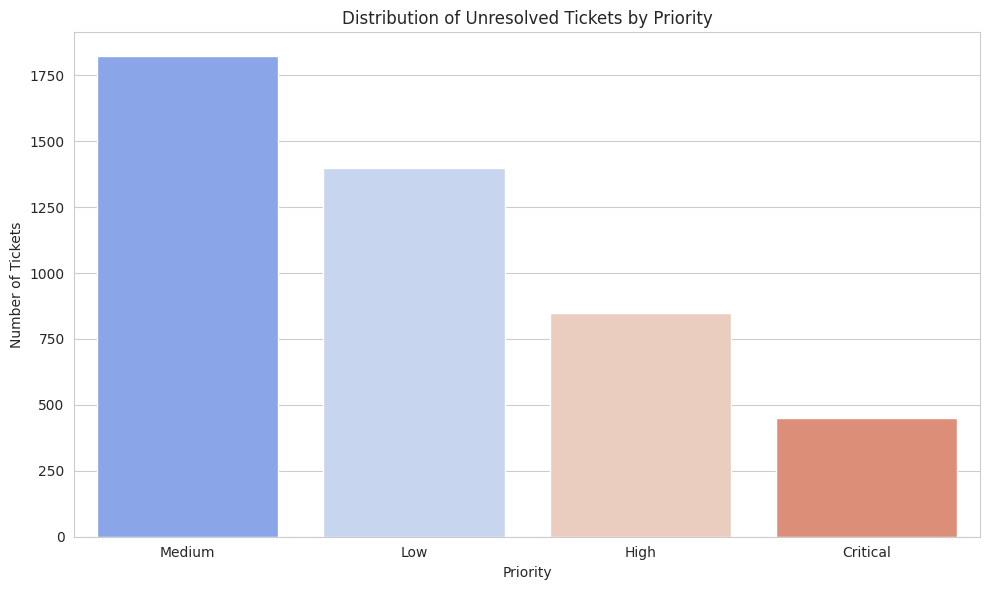

In [ ]:
all_unresolved_tickets = df[df['Status'] != 'Resolved']

plt.figure(figsize=(10, 6))
sns.countplot(data=all_unresolved_tickets, x='Priority', order=all_unresolved_tickets['Priority'].value_counts().index, palette='coolwarm')
plt.title('Distribution of Unresolved Tickets by Priority')
plt.xlabel('Priority')
plt.ylabel('Number of Tickets')
plt.tight_layout()
plt.show()

Module 6:- Geographic and Category-Level Insights

In [ ]:

ticket_concentration_by_country = df['Country'].value_counts().sort_values(ascending=False)
print("--- Ticket Concentration by Country ---")
display(ticket_concentration_by_country)

--- Ticket Concentration by Country ---


,count
Country,
India,1036
UK,1022
Germany,1001
USA,991
Brazil,950


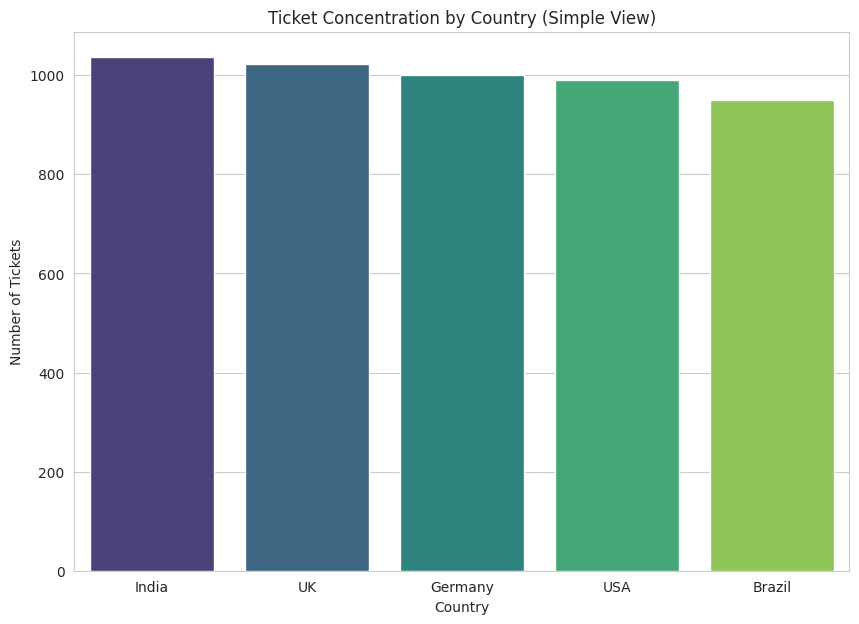

In [ ]:
plt.figure(figsize=(10, 7))
sns.barplot(x=ticket_concentration_by_country.index, y=ticket_concentration_by_country.values, hue=ticket_concentration_by_country.index, palette='viridis', legend=False)
plt.title('Ticket Concentration by Country (Simple View)')
plt.xlabel('Country')
plt.ylabel('Number of Tickets')
plt.show()

--- Ticket Concentration by Country and Category (Heatmap Data) ---


Category,Hardware,Network,Security,Software
Country,,,,
Brazil,271,215,241,223
Germany,253,261,240,247
India,262,278,241,255
UK,259,256,244,263
USA,253,245,229,264


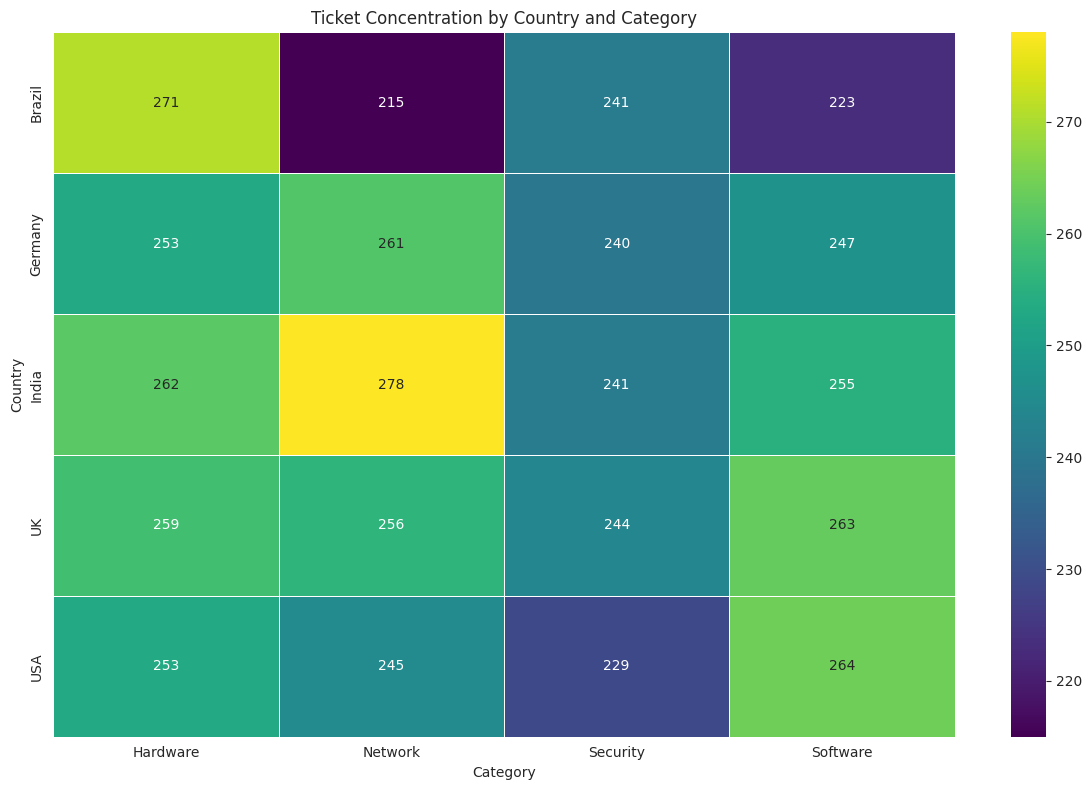

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure df is loaded for robustness, although it should be from previous steps.
if 'df' not in locals():
    try:
        df = pd.read_csv('/content/cleaned_Supportlytics.csv')
    except FileNotFoundError:
        print("Error: 'cleaned_Supportlytics.csv' not found. Please ensure the file is available.")
        raise # Re-raise to prevent further errors

# Calculate ticket concentration by Country and Category
ticket_concentration_pivot = df.groupby(['Country', 'Category']).size().unstack(fill_value=0)

print("--- Ticket Concentration by Country and Category (Heatmap Data) ---")
display(ticket_concentration_pivot)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(ticket_concentration_pivot, annot=True, fmt='d', cmap='viridis', linewidths=.5)
plt.title('Ticket Concentration by Country and Category')
plt.xlabel('Category')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

## Prepare Data for Geographic Plotting


Ensure the DataFrame contains 'Latitude', 'Longitude', and 'Category' columns and handle any missing values if necessary.


In [ ]:
df_geo = df.dropna(subset=['Latitude', 'Longitude', 'Category']).copy()

print(f"Original DataFrame shape: {df.shape}")
print(f"DataFrame for geographic plotting (df_geo) shape after dropping NaNs: {df_geo.shape}")
print("Missing values in df_geo (Latitude, Longitude, Category):")
display(df_geo[['Latitude', 'Longitude', 'Category']].isnull().sum())

Original DataFrame shape: (5000, 24)
DataFrame for geographic plotting (df_geo) shape after dropping NaNs: (5000, 24)
Missing values in df_geo (Latitude, Longitude, Category):


,0
Latitude,0
Longitude,0
Category,0


**Reasoning**:
Now that the data has been prepared and missing values handled, the next step is to create the geographic scatter plot using 'Latitude' and 'Longitude', with 'Category' defining the colors, as specified in the main task.



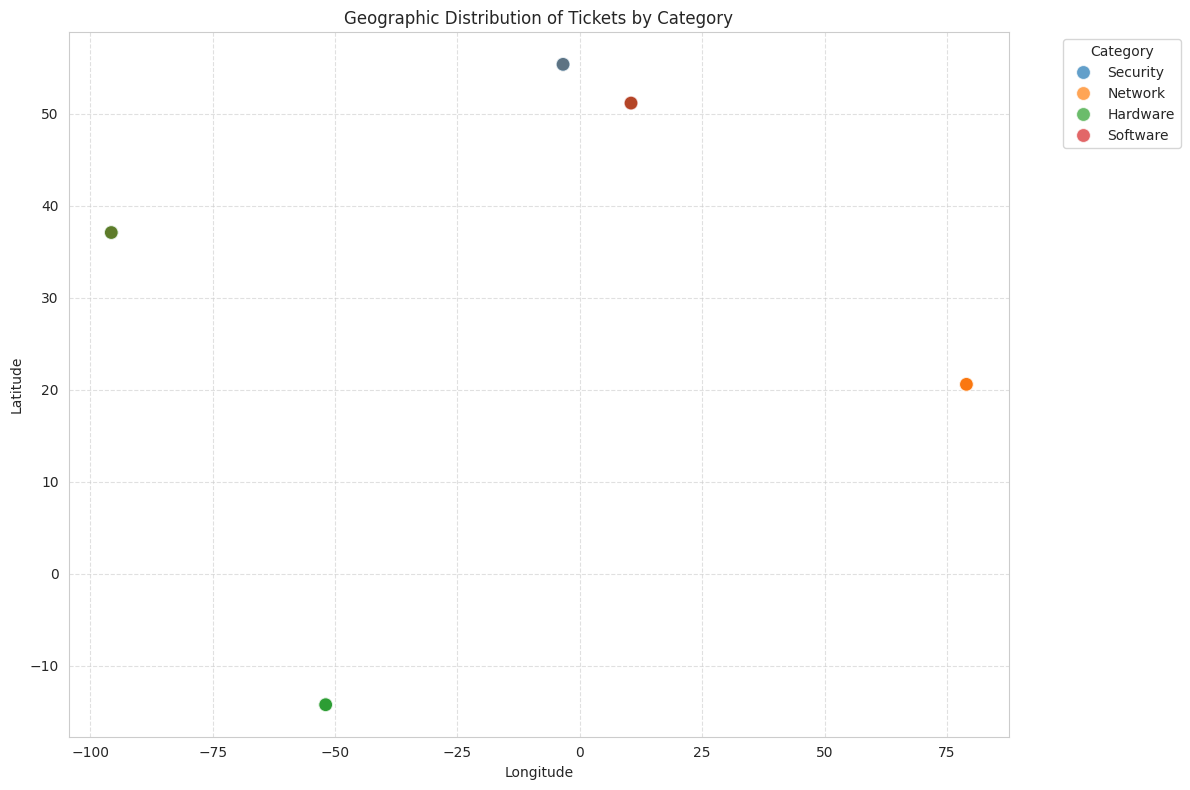

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_geo, x='Longitude', y='Latitude', hue='Category', palette='tab10', s=100, alpha=0.7)
plt.title('Geographic Distribution of Tickets by Category')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Calculate Cluster Sizes


Calculate the number of tickets belonging to each `Cluster_ID` to determine cluster sizes.


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Re-define features for clustering, as df might have been reloaded
features = [
    'Resolution_Duration',
    'Expected_SLA_resolve',
    'Agent_interactions',
    'Normalized_Speed',
    'Normalized_Satisfaction',
    'Similarity_Score'
]

# Ensure only rows with complete feature data are used for clustering
df_clustering = df[features].dropna()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)

# Perform KMeans clustering and assign 'Cluster_ID'
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

# Initialize 'Cluster_ID' column in df with NaN first, to handle rows not included in clustering
df['Cluster_ID'] = np.nan

# Assign cluster IDs only to the rows that were actually used for clustering
df.loc[df_clustering.index, 'Cluster_ID'] = kmeans.fit_predict(X_scaled)

# Calculate cluster sizes. value_counts() will exclude NaN values by default.
cluster_counts = df['Cluster_ID'].value_counts().sort_index()
print("--- Cluster Sizes ---")
display(cluster_counts)

--- Cluster Sizes ---


,count
Cluster_ID,
0.0,1481
1.0,1090
2.0,956
3.0,1237


**Reasoning**:
Now that cluster sizes are calculated, I calculate the average 'Similarity_Score' for each cluster, then combine these two metrics to create a new DataFrame for comparison and display it.



In [ ]:
cluster_similarity_mean = df.groupby('Cluster_ID')['Similarity_Score'].mean().sort_index()

# Combine cluster counts and average similarity score
cluster_performance_summary = pd.DataFrame({
    'Cluster_Size': cluster_counts,
    'Average_Similarity_Score': cluster_similarity_mean
}).dropna()

print("--- Cluster Size vs. Average Similarity Score ---")
display(cluster_performance_summary)

--- Cluster Size vs. Average Similarity Score ---


,Cluster_Size,Average_Similarity_Score
Cluster_ID,,
0.0,1481,0.100403
1.0,1090,0.406902
2.0,956,0.163839
3.0,1237,0.613149


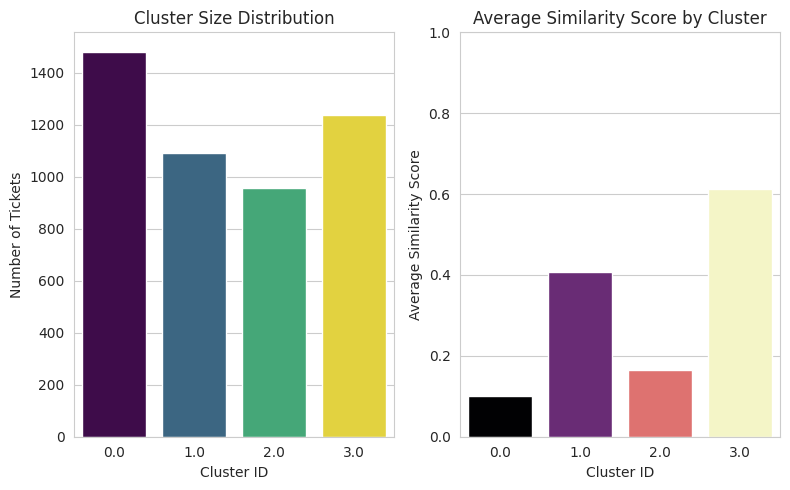

In [ ]:

# Subplot 1: Cluster Size
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
sns.barplot(x=cluster_performance_summary.index, y='Cluster_Size', data=cluster_performance_summary, palette='viridis', hue=cluster_performance_summary.index, legend=False)
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Tickets')

# Subplot 2: Average Similarity Score
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
sns.barplot(x=cluster_performance_summary.index, y='Average_Similarity_Score', data=cluster_performance_summary, palette='magma', hue=cluster_performance_summary.index, legend=False)
plt.title('Average Similarity Score by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Average Similarity Score')
plt.ylim(0, 1) # Similarity scores are normalized between 0 and 1

plt.tight_layout()
plt.show()

In [ ]:
print("--- Performance Metrics Summary (Cluster Size vs. Average Similarity Score) ---")
display(cluster_performance_summary)

--- Performance Metrics Summary (Cluster Size vs. Average Similarity Score) ---


,Cluster_Size,Average_Similarity_Score
Cluster_ID,,
0.0,1481,0.100403
1.0,1090,0.406902
2.0,956,0.163839
3.0,1237,0.613149


In [ ]:

# 1. Avg Resolution Time by Priority
priority_perf = df.groupby('Priority')['Resolution_Duration'].mean().sort_values()

# 2. Avg Resolution Time by Ticket Type (Category)
type_perf = df.groupby('Category')['Resolution_Duration'].mean().sort_values()

# 3. Top Fastest Teams (using Agent_Group, assuming 'fastest' means lowest Resolution_Duration)
team_perf = df.groupby('Agent_Group')['Resolution_Duration'].mean().sort_values()

# 4. Cluster Performance (Avg Resolution Duration by Cluster_ID)
cluster_perf = df.groupby('Cluster_ID')['Resolution_Duration'].mean().sort_values()

# Create the summary dictionary
summary = {
    "Avg Resolution Time by Priority": priority_perf,
    "Avg Resolution Time by Ticket Type": type_perf,
    "Top Fastest Teams": team_perf.head(10),
    "Cluster Performance": cluster_perf
}

# Display the summary
print("--- Concise Performance Metrics Summary ---")
display(summary)

--- Concise Performance Metrics Summary ---


{'Avg Resolution Time by Priority': Priority
 Critical     3.391368
 High         6.865620
 Medium      20.502156
 Low         42.065707
 Name: Resolution_Duration, dtype: float64,
 'Avg Resolution Time by Ticket Type': Category
 Security    14.327702
 Software    14.582803
 Network     30.585237
 Hardware    30.759551
 Name: Resolution_Duration, dtype: float64,
 'Top Fastest Teams': Agent_Group
 L2 Technical Support    22.533463
 Security Admin          22.593904
 L1 Service Desk         22.723935
 Network Ops             22.742103
 Infrastructure          23.055681
 Name: Resolution_Duration, dtype: float64,
 'Cluster Performance': Cluster_ID
 1.0     9.908706
 3.0    12.369992
 0.0    20.615010
 2.0    54.012490
 Name: Resolution_Duration, dtype: float64}